# **Prediction of Pulmonary Fibrosis Progression Using Convolutional Neural Networks (CNN)**

<font size="5">**Importing necessary libraries**</font>

# **Prediction of Pulmonary Fibrosis Progression using Convolutional Neural Networks(CNN)**

<font size='5'>**Importing necessary libraries**</font>

In [1]:
import os
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pydicom
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as Layer
import tensorflow.keras.models as Model

<font size="5">**Loading Datasets**</font>

<font size='3'>Dataset Details
* train.csv - the training set, contains full history of clinical information
* test.csv - the test set, contains only the baseline measurement
* train/ - contains the training patients' baseline CT scan in DICOM format
* test/ - contains the test patients' baseline CT scan in DICOM format</font>

<font size='4'>**Loading patient clinical information from train.csv and test.csv**</font>

In [2]:
Path = "../input/osic-pulmonary-fibrosis-progression"
train_data= pd.read_csv(f"{Path}/train.csv")
test_data=pd.read_csv(f"{Path}/test.csv")

In [3]:
print('Shape of Train data',train_data.shape)
print('Shape of Test data',test_data.shape)

Shape of Train data (1549, 7)
Shape of Test data (5, 7)


In [4]:
train_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
test_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [6]:
train_data["SmokingStatus"].unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

Columns Details in train.csv and test.csv
* Patient - a unique Id for each patient (also the name of the patient's DICOM folder)
* Weeks - the relative number of weeks pre/post the baseline CT (may be negative)
* FVC - the recorded lung capacity in ml
* Percent - a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
* Age - Age of the patient
* Sex - Gender of the patient
* SmokingStatus - Smoking Status of the patient (i.e Ex-Smoker,Never smoked,Currently smokes)

<font size='4'>**Loading patient's CT Scan images from train folder**</font>

<font size='4'>**We are provided with baseline chest CT Scan images of each patient at a weeks intervals**</font>     
<font size='4'>**Digital Imaging and COmmunications in Medicine - DICOM**</font>

<font size='3'>DICOM(Digital Imaging and COmmunications in Medicine) is the de-facto standard that establishes rules that allow medical images(X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals.</font>

<font size='3'>DICOM files typically have a .dcm extension and provides a means of storing data in separate 'tags' such as patient information as well as image/pixel data. A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags.</font>

<font size='3'>By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc.</font>

<font size='4'>**Pydicom**</font>

<font size='3'>Pydicom is a python package for parsing DICOM files and makes it easy to covert DICOM files into pythonic structures for easier manipulation. Files are opened using pydicom.dcmread</font>

In [7]:
#FETCH UNIQUE PATIENT IDs
Patient_list=train_data["Patient"].unique()

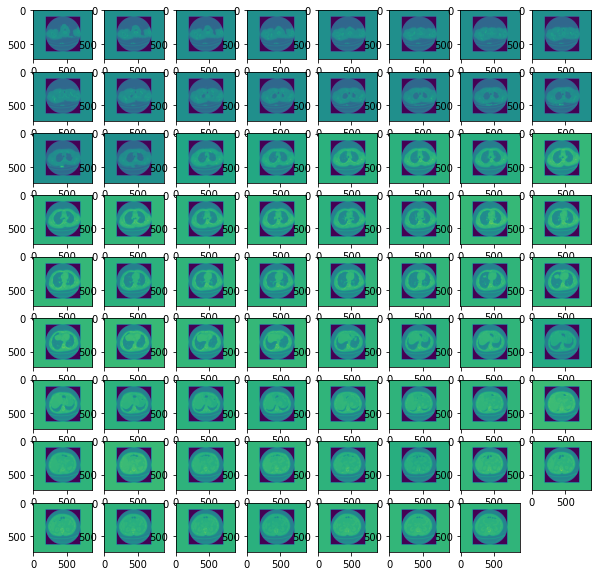

In [8]:
def getDcms(patient,type):
    image_dir = f"{Path}/{type}/{patient}"
    fig=plt.figure(figsize=(10,10))
    image_list = os.listdir(image_dir)#name of the files in the train folder
    columns = int(np.sqrt(len(image_list)))#8 
    rows = columns+1#9
    dcms=[]
    for i in range(1, len(image_list) +1):
        ds = pydicom.dcmread(image_dir + "/" + str(i) + ".dcm")
        dcms.append(ds.pixel_array)
        fig.add_subplot(rows,columns,i)
        plt.imshow(ds.pixel_array)
    return dcms

img_list=getDcms(Patient_list[50],"train" )#displaying 50th patient ct scans

<font size='5'>**Data Preprocessing**</font>

In [9]:
#Check for missing values
train_data.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [10]:
#Drop records having same Patient ID and week
train_data.drop_duplicates(subset=['Patient', 'Weeks'], keep=False, inplace=True)

In [11]:
train_data.shape

(1535, 7)

In [12]:
#GENERATE NEW COLUMNS LIKE BaslineWeek,BaselineFVC,TargetWeek,TargetFVC
train_new = []
for p in train_data['Patient'].unique():
    patientData = train_data[train_data['Patient'] == p]
    firstMeasure = list(patientData.iloc[0, :].values)
  
    for i, week in enumerate(patientData['Weeks'].iloc[1:]):
        fvc = patientData.iloc[i, 2]
        trainDataPoint = firstMeasure + [week, fvc]
        train_new.append(trainDataPoint)
    
        
train_new = pd.DataFrame(train_new)

train_new.columns = ['PatientID', 'BaselineWeek', 'BaselineFVC', 'first_Percent', 'Age', 'Sex', 'SmokingStatus'] + ['TargetWeek', 'TargetFVC']

#Dropping percent column since it was increasing the loss
train_new.drop(columns = ['first_Percent'], inplace = True)

train_new.head()

,PatientID,BaselineWeek,BaselineFVC,Age,Sex,SmokingStatus,TargetWeek,TargetFVC
0,ID00007637202177411956430,-4,2315,79,Male,Ex-smoker,5,2315
1,ID00007637202177411956430,-4,2315,79,Male,Ex-smoker,7,2214
2,ID00007637202177411956430,-4,2315,79,Male,Ex-smoker,9,2061
3,ID00007637202177411956430,-4,2315,79,Male,Ex-smoker,11,2144
4,ID00007637202177411956430,-4,2315,79,Male,Ex-smoker,17,2069


In [13]:
train_new.shape

(1359, 8)

<font size='5'>**Image Preprocessing**</font>

<font size='4'>**Fetch the CT Scan from the patient's folder for the given target week**</font>

In [14]:
def get_Weeks_Dcms(type):
    fig=plt.figure(figsize=(10,10))
    dcms=[]
    plist=[]
    wlist=[]
    for p in Patient_list:
        image_dir = f"{Path}/{type}/{p}"
        week=train_new[train_new["PatientID"]==p]["TargetWeek"]
        for w in week:
            try:
                ds = pydicom.dcmread(image_dir + "/" + str(w) + ".dcm")
                dcms.append(ds.pixel_array)
                #plt.imshow(ds.pixel_array)
                plist.append(p)
                wlist.append(w)
            except:
                pass
    data = pd.DataFrame({"PatientID":plist,"TargetWeek":wlist})        
    return dcms,data

In [15]:
train_img,train_patweek=get_Weeks_Dcms("train")

<Figure size 720x720 with 0 Axes>

In [16]:
#Resizing the images
for i in range(0,len(train_img)):
    im = Image.fromarray(train_img[i])
    im = im.resize((128,128),resample=Image.NEAREST) 
    train_img[i] = np.array(im).reshape((128,128,1))

In [17]:
print(len(train_img))
print(train_patweek.shape)

1096
(1096, 2)


In [18]:
train_img=np.array(train_img)

In [19]:
train_new = pd.merge(train_patweek,train_new, how="left", on=['PatientID',"TargetWeek"])

In [20]:
train_new.shape

(1096, 8)

In [21]:
print(train_img.shape)

(1096, 128, 128, 1)


In [22]:
#ENCODING Sex and SmokingStatus
train_new["Sex"]=train_new["Sex"].astype("category").cat.codes
train_new["SmokingStatus"]=train_new["SmokingStatus"].astype("category").cat.codes

In [23]:
train_new.head()

,PatientID,TargetWeek,BaselineWeek,BaselineFVC,Age,Sex,SmokingStatus,TargetFVC
0,ID00007637202177411956430,5,-4,2315,79,1,1,2315
1,ID00007637202177411956430,7,-4,2315,79,1,1,2214
2,ID00007637202177411956430,9,-4,2315,79,1,1,2061
3,ID00007637202177411956430,11,-4,2315,79,1,1,2144
4,ID00007637202177411956430,17,-4,2315,79,1,1,2069


<font size='5'>**MinMax Normalization**</font>

In [24]:
train_new["TargetWeek"]=(train_new['TargetWeek'] - train_new['TargetWeek'].min() ) / ( train_new['TargetWeek'].max() - train_new['TargetWeek'].min() )
train_new["Age"]=(train_new['Age'] - train_new['Age'].min() ) / ( train_new['Age'].max() - train_new['Age'].min() )
train_new["BaselineWeek"]=(train_new['BaselineWeek'] - train_new['BaselineWeek'].min() ) / ( train_new['BaselineWeek'].max() - train_new['BaselineWeek'].min() )
train_new["BaselineFVC"]=(train_new['BaselineFVC'] - train_new['BaselineFVC'].min() ) / ( train_new['BaselineFVC'].max() - train_new['BaselineFVC'].min() )

In [25]:
x_min = np.min(train_img)
x_max = np.max(train_img)
train_img_scaled = train_img - x_min / (x_max - x_min)

In [26]:
train_new.head()

,PatientID,TargetWeek,BaselineWeek,BaselineFVC,Age,Sex,SmokingStatus,TargetFVC
0,ID00007637202177411956430,0.034783,0.014706,0.241456,0.789474,1,1,2315
1,ID00007637202177411956430,0.052174,0.014706,0.241456,0.789474,1,1,2214
2,ID00007637202177411956430,0.069565,0.014706,0.241456,0.789474,1,1,2061
3,ID00007637202177411956430,0.086957,0.014706,0.241456,0.789474,1,1,2144
4,ID00007637202177411956430,0.139130,0.014706,0.241456,0.789474,1,1,2069


In [27]:
train_new.columns

Index(['PatientID', 'TargetWeek', 'BaselineWeek', 'BaselineFVC', 'Age', 'Sex',
       'SmokingStatus', 'TargetFVC'],
      dtype='object')

In [28]:
target=train_new["TargetFVC"].values
features=train_new[[ 'BaselineWeek', 'BaselineFVC', 'Age', 'Sex',
       'SmokingStatus','TargetWeek']]

In [29]:
features.shape,target.shape,train_img_scaled.shape

((1096, 6), (1096,), (1096, 128, 128, 1))

<font size='5'>**Defining function for Loss calculation**</font>

<font size='4'>**Loss Calculation is done using Laplace Likelihood**</font>

* <font size='4'>For each true FVC measurement, you will predict both an FVC and a confidence measure (standard deviation σ).</font>
* <font size='4'>Confidence values smaller than 70 are clipped.</font>
* <font size='4'>Errors greater than 1000 are also clipped in order to avoid large errors.</font>

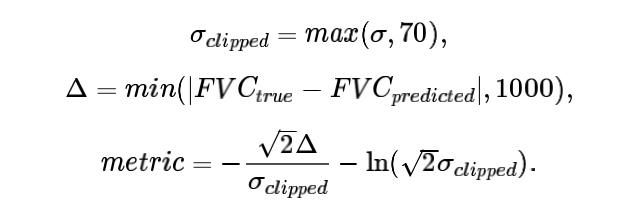

In [30]:
C70, C10 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def LaplaceLogLikelihood(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    
    sigma_clip = tf.maximum(y_pred[:, 1], C70)
    
    delta = tf.minimum(tf.abs(y_true[:, 0] - y_pred[:, 0]), C10)
  
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def regressionloss (y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

def OSICloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * LaplaceLogLikelihood(y_true, y_pred) + (1 - _lambda)*regressionloss(y_true, y_pred)
    return loss
#=================

2022-07-27 13:56:49.087273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 13:56:49.183252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 13:56:49.184029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 13:56:49.187297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<font size='5'>**Architecture of CNN model**</font>

In [31]:
def model_1D():
    ct = Layer.Input((128,128), name="input")
    Patient = Layer.Input((6,), name="Patient")
    x = Layer.Conv1D(50, 4, activation="relu", name="conv1")(ct)
    x = Layer.MaxPool1D(2, name='pool1')(x)   
    x = Layer.Conv1D(50, 4, activation="relu", name="conv2")(x)
    x = Layer.MaxPool1D(2, name='pool2')(x)  
    x = Layer.Conv1D(50, 4, activation="relu", name="conv3")(x)
    x = Layer.MaxPool1D(2, name='pool3')(x) 
    x = Layer.Flatten(name="features")(x)
    x = Layer.Dense(50, activation="relu", name="d1")(x)
    l = Layer.Dense(10, activation="relu", name="d2")(Patient)
    x = Layer.Concatenate(name="combine")([x, l])
    x = Layer.Dense(50, activation="relu", name="d3")(x)
    preds = Layer.Dense(2, activation="relu", name="preds")(x)    
    model = Model.Model([ct, Patient], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
   
    return model

In [32]:
net_1D = model_1D()
print(net_1D.summary())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 125, 50)      25650       input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling1D)            (None, 62, 50)       0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 59, 50)       10050       pool1[0][0]                      
________________________________________________________________________________________________

In [33]:
target=target.astype("float32")

<font size='5'>**Train the model**</font>

In [34]:
net_1D.fit([train_img_scaled, features], target, batch_size=50, epochs=100) 

2022-07-27 13:56:52.236809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-27 13:56:55.140183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


22/22 [==============================] - 8s 9ms/step - loss: 6.0551 - LaplaceLogLikelihood: 11.5452
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 4.2758 - LaplaceLogLikelihood: 8.2410
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 4.1895 - LaplaceLogLikelihood: 8.0959
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 4.1708 - LaplaceLogLikelihood: 8.0630
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 4.1163 - LaplaceLogLikelihood: 7.9796
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 4.0923 - LaplaceLogLikelihood: 7.9470
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 4.0740 - LaplaceLogLikelihood: 7.9163
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 4.0705 - LaplaceLogLikelihood: 7.9141
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 4.0270 - LaplaceLogLikelihood: 7.8394
Epoch 10/100

<font size='5'>**Save the model and weights**</font>

In [35]:
net_1D.save('cnn_final.h5')

<font size='5'>**Prediction using model**</font>

In [36]:
predict_1D=net_1D.predict([train_img_scaled, features], batch_size=100, verbose=1)

11/11 [==============================] - 0s 8ms/step


<font size='5'>**Evaluation**</font>

In [37]:
## evaluation metric function
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


## default benchmark
laplace_log_likelihood(target, predict_1D[:,0],predict_1D[:,1])

-6.182938